In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.serialize import model_to_json, model_from_json

import sys
sys.path.append('..')
from src.data.dataset_generator import DatasetGenerator
from src.data.data_transformer import DataTransformer

#import utils
import itertools
import json

In [4]:
dg = DatasetGenerator(['all'])
dataset_latest = dg.get_dataset('2016-01-01', 'latest', 'ignored')

Repaired missing entsoe data from dates: ['2021-08-13']
Data coverage 100%
Data coverage 100%


In [5]:
# Extract Length, and Timerange of the Downloaded Dataset
X = dataset_latest.Time

datapoints = X.index.max()
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))

# Change Index from Dataframe (new index: Time)
data_hourly = dataset_latest.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')
data_hourly=data_hourly.reset_index()

Number of datapoints in the Dataset: 49247
Minimum date from data set: 2016-01-01 00:00:00
Maximum date from data set: 2021-08-13 23:00:00


In [6]:
# unit: €/MWh
data_hourly

,index,SPOTPrice,Load,Solar,Wind Offshore,Wind Onshore,temp_muc,dwpt_muc,rhum_muc,prcp_muc,wspd_muc,pres_muc,tsun_muc,temp_ham,dwpt_ham,rhum_ham,prcp_ham,wspd_ham,pres_ham,tsun_ham
0,2016-01-01 00:00:00,23.86,50211.00,0.00,2275.25,6601.25,5.2,4.9,98.0,0.1,1.4,1026.6,0.0,2.4,2.0,97.0,0.0,6.1,1023.4,0.0
1,2016-01-01 01:00:00,22.39,48192.75,0.00,2285.50,6445.75,4.7,4.6,99.0,0.0,3.2,1026.4,0.0,2.0,2.0,100.0,0.0,9.4,1023.5,0.0
2,2016-01-01 02:00:00,20.59,46264.75,0.00,2228.75,6422.75,3.8,3.7,99.0,0.5,4.3,1026.9,0.0,2.0,2.0,100.0,0.0,9.4,1023.4,0.0
3,2016-01-01 03:00:00,16.81,44942.00,0.00,2011.50,6487.00,4.0,3.9,99.0,0.5,4.0,1027.4,0.0,1.4,1.0,97.0,0.0,9.7,1023.4,0.0
4,2016-01-01 04:00:00,17.41,44431.50,0.00,1942.75,6391.25,4.0,3.9,99.0,0.6,4.0,1027.5,0.0,1.0,0.6,97.0,0.0,7.6,1023.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49243,2021-08-13 19:00:00,117.48,58170.25,2933.75,590.50,1050.50,25.0,17.5,63.0,0.0,9.3,1020.7,0.0,18.9,14.2,74.0,0.0,14.8,1019.5,0.0
49244,2021-08-13 20:00:00,115.68,58170.25,2933.75,590.50,1050.50,25.0,17.5,63.0,0.0,9.3,1020.7,0.0,18.9,14.2,74.0,0.0,14.8,1019.5,0.0
49245,2021-08-13 21:00:00,115.77,58170.25,2933.75,590.50,1050.50,25.0,17.5,63.0,0.0,9.3,1020.7,0.0,18.9,14.2,74.0,0.0,14.8,1019.5,0.0
49246,2021-08-13 22:00:00,106.91,58170.25,2933.75,590.50,1050.50,25.0,17.5,63.0,0.0,9.3,1020.7,0.0,18.9,14.2,74.0,0.0,14.8,1019.5,0.0


In [8]:
data_spot = data_hourly.loc[:, ['index','SPOTPrice']]
data_load = data_hourly.Load
data_solar = data_hourly.Solar
data_off = data_hourly['Wind Offshore']
data_on = data_hourly['Wind Onshore']
data_temp = data_hourly.temp_muc
data_dwpt = data_hourly.dwpt_muc
data_rhum = data_hourly.rhum_muc
data_prcp = data_hourly.prcp_muc
data_wspd = data_hourly.wspd_muc
data_pres = data_hourly.pres_muc
data_tsun = data_hourly.tsun_muc

In [9]:
# switch column names to prophet structure
data_spot = data_spot.rename({'index':'ds', 'SPOTPrice':'y'}, axis=1)
data_spot

,ds,y
0,2016-01-01 00:00:00,23.86
1,2016-01-01 01:00:00,22.39
2,2016-01-01 02:00:00,20.59
3,2016-01-01 03:00:00,16.81
4,2016-01-01 04:00:00,17.41
...,...,...
49243,2021-08-13 19:00:00,117.48
49244,2021-08-13 20:00:00,115.68
49245,2021-08-13 21:00:00,115.77
49246,2021-08-13 22:00:00,106.91


For testing univariant spot price forecasting, subdivide the whole dataset into datasets with the following lengths \
(final week is excluded for the model evaluation; will be changed for a better quality in evaluation):
* previous 5 and 1 year/-s
* previous 6, 3 and 1 month/-s
* previous 3, 2 and 1 week/-s
* previous 5, 4, 3, 2 and 1 day/-s

In [10]:
# Testing set for Walk Forward Evaluation (+1h and +24h)
df_test = data_spot.iloc[-169:]
# Training and Validation Sets for Model Training and Hyperparameter Tuning
df_all = data_spot.iloc[:-169]
df_5a = data_spot.iloc[38568:-169]
df_1a = data_spot.iloc[73632:-169]
df_6m = data_spot.iloc[-4512:-169]
df_3m = data_spot.iloc[-2304:-169]
df_1m = data_spot.iloc[-912:-169]
df_3w = data_spot.iloc[-672:-169]
df_2w = data_spot.iloc[-504:-169]
df_1w = data_spot.iloc[-336:-169]
df_5d = data_spot.iloc[-288:-169]
df_4d = data_spot.iloc[-264:-169]
df_3d = data_spot.iloc[-240:-169]
df_2d = data_spot.iloc[-216:-169]
df_1d = data_spot.iloc[-192:-169]

# Prophet Model
## Crossvalidation on raw data

In [11]:
m = Prophet()
m.add_country_holidays(country_name='Germany')
m.fit(data_spot)

Initial log joint probability = -592.482


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99        109504     0.0129013       6368.74      0.7943      0.7943      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        110065     0.0104906       3576.81           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        110264    0.00347844        5944.3      0.1796      0.1796      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        110391    0.00438274       3803.28           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        110474    0.00943023       2181.93           1           1      588   
    Iter      log prob        ||dx||      |

In [12]:
# initial: history to train on
# period: how much is added to the history after one prediction 
# horizon: how far into the future should be predicted
df_cv = cross_validation(m, initial='2040 days', period='1 day', horizon = '1 hours')

INFO:fbprophet:Making 12 forecasts with cutoffs between 2021-08-02 22:00:00 and 2021-08-13 22:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

Initial log joint probability = -851.544
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        109291    0.00472045        2468.7           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        110052    0.00703398       1218.37       2.192      0.2192      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        110151    0.00324566       5411.44      0.7285      0.7285      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        110387    0.00468216        4406.8      0.2696      0.2696      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        110474    0.00213214       1991.13      0.7631      0.7631      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -450.461
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        109453     0.0188526       16924.8      0.2965           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        110127     0.0168475       14316.5           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        110260     0.0132409       4888.38      0.0753           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        110511    0.00885651       1853.14           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        110603    0.00327028       583.902           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -264.316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        109271    0.00524967       6452.12           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        109965    0.00961949       5480.88      0.1982           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        110131     0.0107077        3812.2      0.4454           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        110229   0.000247532        848.81      0.5155      0.5155      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        110334    0.00306327       3818.21           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -1150.58
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        109383     0.0095764       20925.4      0.3479           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        110058    0.00553183        1827.9           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        110186    0.00388421       4053.03      0.3125      0.3125      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        110349    0.00828968       2344.23        0.81        0.81      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        110419     0.0170452       2937.44           1           1      593   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -891.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        109315     0.0115268       6797.78           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        110111    0.00284723       2923.96           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        110200     0.0276803       12167.8           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        110301     0.0177336       2548.99           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        110531    0.00555347       2702.19           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [13]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-08-02 23:00:00,80.310376,63.422846,95.483460,92.91,2021-08-02 22:00:00
1,2021-08-03 23:00:00,78.663296,62.765006,94.600835,90.82,2021-08-03 22:00:00
2,2021-08-04 23:00:00,80.221576,63.463920,94.933271,90.03,2021-08-04 22:00:00
3,2021-08-05 23:00:00,79.688995,63.732894,95.527202,70.60,2021-08-05 22:00:00
4,2021-08-06 23:00:00,77.081074,60.708643,92.749693,67.56,2021-08-06 22:00:00
5,2021-08-07 23:00:00,64.190750,46.899775,80.177055,58.02,2021-08-07 22:00:00
6,2021-08-08 23:00:00,68.994571,52.929138,85.855616,56.58,2021-08-08 22:00:00
7,2021-08-09 23:00:00,78.704992,61.764747,94.818658,83.65,2021-08-09 22:00:00
8,2021-08-10 23:00:00,77.382179,61.111718,94.347530,92.25,2021-08-10 22:00:00
9,2021-08-11 23:00:00,79.386988,62.646039,95.871868,103.00,2021-08-11 22:00:00


In [14]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 01:00:00,211.766513,14.5522,13.09466,0.153048,0.138269,0.833333


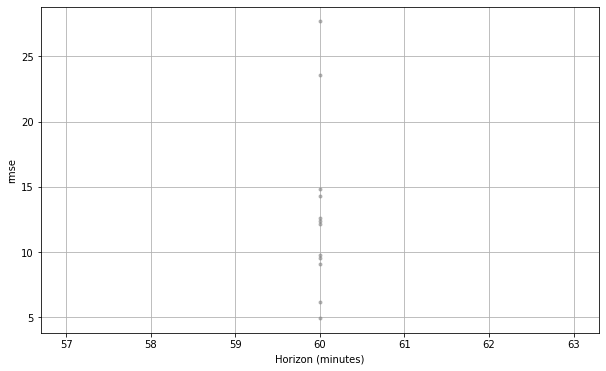

In [15]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

Text(55.25, 0.5, 'Daily seasonality')

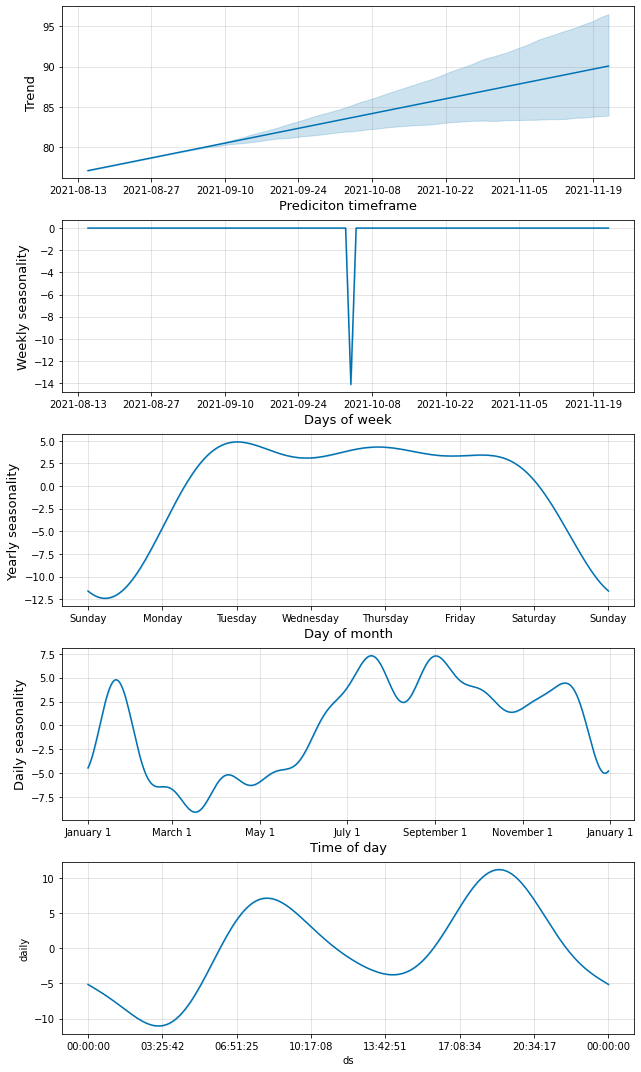

In [16]:
future = m.make_future_dataframe(periods=100, freq='24h', include_history = False)
forecast = m.predict(future)
f = m.plot_components(forecast)
f.get_children()[1].set_xlabel('Prediciton timeframe',  fontsize=13)
f.get_children()[2].set_xlabel('Days of week', fontsize=13)
f.get_children()[3].set_xlabel('Day of month', fontsize=13)
f.get_children()[4].set_xlabel('Time of day', fontsize=13)
f.get_children()[1].set_ylabel('Trend', fontsize=13)
f.get_children()[2].set_ylabel('Weekly seasonality', fontsize=13)
f.get_children()[3].set_ylabel('Yearly seasonality', fontsize=13)
f.get_children()[4].set_ylabel('Daily seasonality', fontsize=13)

# Hyperparameter tuning

important to remember for cross validation:
### initial: 
history to train on
### period: 
how much is added to the history after one prediction 
### horizon: 
how far into the future should be predicted

## Tuning 1h prediction

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.5, 0.7, 0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_all)  # Fit model with given params
    df_cv = cross_validation(m, initial='2030 days', period='1 day', horizon = '1 hours', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

## Tuning 24h prediction

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 0.7, 0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_all)  # Fit model with given params
    df_cv = cross_validation(m, initial='2000 days',period = '4 days', horizon='1 day', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results2 = pd.DataFrame(all_params)
tuning_results2['rmse'] = rmses
print(tuning_results2)

In [ ]:
best_params2 = all_params[np.argmin(rmses)]
print(best_params2)

## Tuning 1 week prediciton

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 0.8],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_all)  # Fit model with given params
    df_cv = cross_validation(m, initial='1900 days', period = '7 days', horizon='7 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results3 = pd.DataFrame(all_params)
tuning_results3['rmse'] = rmses
print(tuning_results3)

In [ ]:
best_params3 = all_params[np.argmin(rmses)]
print(best_params3)

## Tuning with additional features

Possible if no prediction for features avalaible??

## Testing 1h prediction

In [97]:
mh1 = Prophet(changepoint_prior_scale = 0.8, seasonality_prior_scale = 0.1, yearly_seasonality = True)
mh1.add_country_holidays(country_name='Germany')
# fit on 425 days
mh1.fit(data_spot[39000:])

In [100]:
df_cv = cross_validation(mh1, initial='424 days', period='1 hours', horizon = '1 hours')

INFO:fbprophet:Making 23 forecasts with cutoffs between 2021-08-11 00:00:00 and 2021-08-11 22:00:00


  0%|          | 0/23 [00:00<?, ?it/s]

In [107]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 01:00:00,869.145914,29.481281,27.060173,0.257722,0.261335,0.304348


## Testing 1d prediction

In [106]:
md1 = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 5.0, yearly_seasonality = True)
md1.add_country_holidays(country_name='Germany')
md1.fit(data_spot[39000:])

In [113]:
df_cv_d1 = cross_validation(md1, initial='423 days', period='1 hours', horizon = '1 day')

INFO:fbprophet:Making 24 forecasts with cutoffs between 2021-08-10 00:00:00 and 2021-08-10 23:00:00


  0%|          | 0/24 [00:00<?, ?it/s]

In [114]:
df_p_d1 = performance_metrics(df_cv_d1)
df_p_d1

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 03:00:00,684.341813,26.159928,23.465805,0.240814,0.254840,0.405702
1,0 days 04:00:00,715.532967,26.749448,24.322951,0.249774,0.256815,0.346491
2,0 days 05:00:00,748.270223,27.354528,25.165113,0.258503,0.262801,0.287281
3,0 days 06:00:00,782.743082,27.977546,26.016134,0.267154,0.277993,0.239035
4,0 days 07:00:00,826.752426,28.753303,26.964299,0.275822,0.284582,0.197368
5,0 days 08:00:00,902.109496,30.035138,28.109236,0.284254,0.288819,0.173246
6,0 days 09:00:00,967.539172,31.105292,29.000365,0.290316,0.292551,0.149123
7,0 days 10:00:00,1001.311838,31.643512,29.467119,0.293693,0.292551,0.131579
8,0 days 11:00:00,1011.556936,31.804983,29.586501,0.294779,0.297223,0.125000
9,0 days 12:00:00,1019.734962,31.933289,29.633739,0.295257,0.297440,0.142544


## Testing 1w prediction

In [ ]:
#not tuned yet
mw1 = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 5.0, yearly_seasonality = True)
mw1.add_country_holidays(country_name='Germany')
mw1.fit(data_spot[39000:])

In [116]:
df_cv_w1 = cross_validation(md1, initial='416 days', period='1 hours', horizon = '7 days')

INFO:fbprophet:Making 48 forecasts with cutoffs between 2021-08-03 00:00:00 and 2021-08-04 23:00:00


  0%|          | 0/48 [00:00<?, ?it/s]

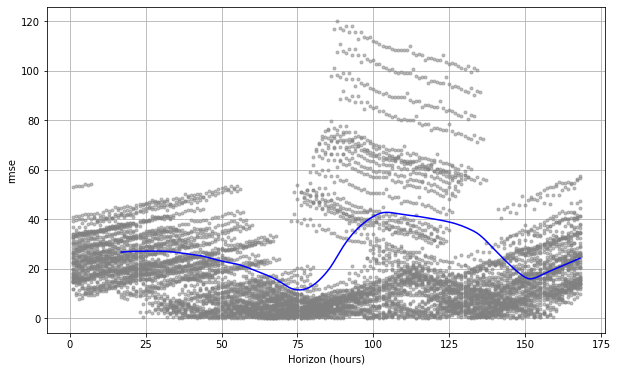

In [125]:
df_p_w1 = performance_metrics(df_cv_w1)
fig = plot_cross_validation_metric(df_cv_w1, metric='rmse')

# Future Prediction

## 1 hour

In [124]:
#create data point we want to predict
future_1h = mh1.make_future_dataframe(periods=1, freq='1h', include_history = False)
print(future_1h)
y_1h = mh1.predict(future_1h)
y_1h

          ds
0 2021-08-12


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christi Himmelfahrt,Christi Himmelfahrt_lower,Christi Himmelfahrt_upper,Erster Mai,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-08-12,76.455298,55.911006,92.8355,76.455298,76.455298,0.0,0.0,0.0,0.0,...,5.092914,5.092914,5.092914,-3.058633,-3.058633,-3.058633,0.0,0.0,0.0,74.174845


## 1 day

In [118]:
#create data point we want to predict
future_1d = md1.make_future_dataframe(periods=1, freq='24h', include_history = False)
print(future_1d)
y_1d = md1.predict(future_1d)

                   ds
0 2021-08-12 23:00:00


## 1 week

In [150]:
# change to md1 to mw1, after tuning this model 

In [121]:
#create data point we want to predict
future_1w = md1.make_future_dataframe(periods=1, freq='168h', include_history = False)
print(future_1w)
y_1w = md1.predict(future_1w)

                   ds
0 2021-08-18 23:00:00


# Saving and loading the model 

In [ ]:
# example code for saving and loading the models 

In [ ]:
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model